In [1]:
!pip install PyTDC rdkit==2023.03.1 DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
split = data.get_split('scaffold',seed=4)

Found local copy...
Loading...
Done!
100%|██████████| 910/910 [00:00<00:00, 1306.37it/s]


In [3]:
split['train'].shape

(637, 3)

In [4]:
split['test'].shape

(182, 3)

In [5]:
split['valid'].shape

(91, 3)

In [6]:
split['train']

,Drug_ID,Drug,Y
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999
3,Dexloxiglumide,CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(...,-5.140131
4,Ac-D-phe-NH2,CC(=O)N[C@@H](Cc1ccccc1)C(N)=O,-5.100090
...,...,...,...
632,ceftriaxone,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,-6.765000
633,indobufen,CCC(C(=O)O)c1ccc(N2Cc3ccccc3C2=O)cc1,-4.390000
634,Phencyclidine (PCP),c1ccc(C2(N3CCCCC3)CCCCC2)cc1,-4.480000
635,Bromazepam,O=C1CN=C(c2ccccn2)c2cc(Br)ccc2N1,-4.400000


In [7]:
import rdkit
rdkit.__version__

'2023.03.1'

In [8]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools, Descriptors, AllChem, AddHs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
import deepchem as dc 

In [9]:
# Let's add the structures to the dataframe
PandasTools.AddMoleculeColumnToFrame(split['train'], 'Drug', 'Molecule')
PandasTools.AddMoleculeColumnToFrame(split['test'], 'Drug', 'Molecule')
PandasTools.AddMoleculeColumnToFrame(split['valid'], 'Drug', 'Molecule')

In [10]:
train = split['train']
test = split['test']
valid = split['valid']

In [11]:
# There are no hydrogens in these structures. 
for idx, mol in enumerate(train.Molecule):            # Training set
  train.Molecule[idx] = rdkit.Chem.AddHs(mol)

for idx, mol in enumerate(test.Molecule):             # Test set
  test.Molecule[idx] = rdkit.Chem.AddHs(mol)

for idx, mol in enumerate(valid.Molecule):            # Validation set
  valid.Molecule[idx] = rdkit.Chem.AddHs(mol)

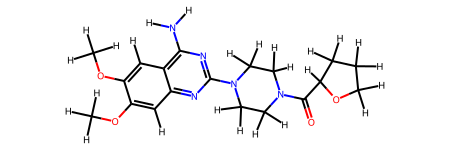

In [12]:
train.Molecule.iloc[-1]

In [13]:
# Let's generate Morgan Fingerprints

In [14]:
mol = train.Molecule.iloc[-1]

In [15]:
# Make a featurizer object
featurizer = dc.feat.CircularFingerprint(size=1024, chiral=True, bonds=True, radius=3)  # Can tune the model with these arguments

In [16]:
features = featurizer.featurize(mol)

In [17]:
type(features)

numpy.ndarray

In [18]:
features[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
features.shape

(1, 1024)

In [20]:
# Make a new series that stores the fingerprints
train['FingerP'] = train['Molecule'].apply(featurizer.featurize)
test['FingerP'] = test['Molecule'].apply(featurizer.featurize)
valid['FingerP'] = valid['Molecule'].apply(featurizer.featurize)

In [21]:
train.sample(5)

,Drug_ID,Drug,Y,Molecule,FingerP
372,propranolol ester,CC(C)NC[C@H](COc1cccc2ccccc12)OC(=O)C1CC1,-4.510000,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd0103c0>,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
515,LY366659,CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3c(F)...,-4.200000,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd0142e0>,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
59,Pranoprofen; pyranoprofen,CC(C(=O)O)c1ccc2c(c1)Cc1cccnc1O2,-4.390000,<rdkit.Chem.rdchem.Mol object at 0x7f6ebcfbfa70>,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
79,MMMDPB,COCN1C(=O)NC(=O)C(c2ccccc2)(c2ccccc2)C1=O,-4.500000,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd0003c0>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
25,Vorinostat (SAHA-suberoylanilide hydroxamic acid),O=C(CCCCCCC(=O)Nc1ccccc1)NO,-5.629466,<rdkit.Chem.rdchem.Mol object at 0x7f6ebcfbeb90>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [22]:
# Convert the FingerP array to list
train['FingerP'] = train['FingerP'].apply(lambda x: list(x[0]))
test['FingerP'] = test['FingerP'].apply(lambda x: list(x[0]))
valid['FingerP'] = valid['FingerP'].apply(lambda x: list(x[0]))

In [23]:
train.sample(1)

,Drug_ID,Drug,Y,Molecule,FingerP
238,Furazolidone,O=C1OCCN1/N=C/c1ccc(N(O)O)o1,-4.99,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd0049e0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
train.FingerP

0      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
632    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
633    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
634    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
635    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
636    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: FingerP, Length: 637, dtype: object

In [25]:
train.head()

,Drug_ID,Drug,Y,Molecule,FingerP
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd01f3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a810>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Dexloxiglumide,CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(...,-5.140131,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd72d8c0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Ac-D-phe-NH2,CC(=O)N[C@@H](Cc1ccccc1)C(N)=O,-5.100090,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd72edc0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
test.head()

,Drug_ID,Drug,Y,Molecule,FingerP
0,VLA-4 antagonist 2,CCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@...,-5.37,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd017840>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,VLA-4 antagonist 3,CC(C)OC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)...,-5.17,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a340>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,VLA-4 antagonist 4,CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O...,-5.34,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b220>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,VLA-4 antagonist 5,CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O...,-5.60,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd72c820>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,VLA-4 antagonist 6,COCCOCCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=...,-5.69,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd0178b0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
test.shape

(182, 5)

In [28]:
len(train)

637

In [29]:
len(test)

182

In [30]:
des_featurizer = dc.feat.RDKitDescriptors()

In [31]:
train['descriptors'] = train['Molecule'].apply(des_featurizer.featurize)
test['descriptors'] = test['Molecule'].apply(des_featurizer.featurize)
valid['descriptors'] = valid['Molecule'].apply(des_featurizer.featurize)

In [32]:
train.head(3)

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd01f3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[11.154602831335577, 11.154602831335577, 0.33..."
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a810>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[12.420644498002243, 12.420644498002243, 0.60..."
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[13.475783533320733, 13.475783533320733, 1.09..."


In [33]:
# Convert the descriptors array to list
train['descriptors'] = train['descriptors'].apply(lambda x: list(x[0]))
test['descriptors'] = test['descriptors'].apply(lambda x: list(x[0]))
valid['descriptors'] = valid['descriptors'].apply(lambda x: list(x[0]))

In [34]:
train.head(3)

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd01f3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.154602831335577, 11.154602831335577, 0.338..."
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a810>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.420644498002243, 12.420644498002243, 0.609..."
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.475783533320733, 13.475783533320733, 1.090..."


In [35]:
# Make a new series in the DF with fingerprints and descriptors combined.
train['features'] = train['FingerP'] + train['descriptors']

In [36]:
train.head(3)

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors,features
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd01f3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.154602831335577, 11.154602831335577, 0.338...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a810>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.420644498002243, 12.420644498002243, 0.609...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.475783533320733, 13.475783533320733, 1.090...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
len(train.features[0])

1233

In [38]:
# Do the same for test and valid sets
test['features'] = test['FingerP'] + test['descriptors']
valid['features'] = valid['FingerP'] + valid['descriptors']

In [39]:
len(test.features[0])

1233

In [40]:
des_keys = Descriptors.CalcMolDescriptors(train.Molecule[0]).keys()
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [41]:
# Separate the descriptors into columns
def get_des(data_set):
  for idx, mol in enumerate(data_set.Molecule):
    all_des = Descriptors.CalcMolDescriptors(mol)
    for des in des_keys:
      data_set.loc[idx,des] = all_des[des]


In [42]:
get_des(train)
get_des(test)
get_des(valid)

In [43]:
train.head(3)

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors,features,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd01f3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.154602831335577, 11.154602831335577, 0.338...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.154603,11.154603,0.338357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,H 244/45,CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1,-5.219842,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71a810>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.420644498002243, 12.420644498002243, 0.609...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12.420644,12.420644,0.609815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,D-Phe-D-Ala-D-Ser-OH,C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)...,-6.281999,<rdkit.Chem.rdchem.Mol object at 0x7f6ebd71b3e0>,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.475783533320733, 13.475783533320733, 1.090...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13.475784,13.475784,1.090283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# A function to drop all the NULL values
def drop_nulls(df):
    null_idxs = df[df.isnull().any(axis=1)].index.tolist()
    for idx in null_idxs:
        print('Dropping datapoints with NULL data')
        df = df.drop([idx])
        print(f'Index {idx} was dropped')

    return df

In [51]:
train = drop_nulls(train)
test = drop_nulls(test)
valid = drop_nulls(valid)

Dropping datapoints with NULL data
Index 349 was dropped
Dropping datapoints with NULL data
Index 37 was dropped


In [52]:
# We have dropped it! 

In [53]:
train.shape

(636, 216)

In [54]:
valid[valid.isnull().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors,features,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [55]:
train[train.isnull().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,FingerP,descriptors,features,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [56]:
# We have dropped it!

In [57]:
y_train = train.Y
y_test = test.Y
y_valid = valid.Y

In [58]:
print(y_valid.shape)
print(valid.shape)

(90,)
(90, 216)


In [59]:
import xgboost

In [60]:
# Make an object
xgb_reg = xgboost.XGBRegressor(n_estimators = 5000,
                                  max_depth = 10,
                                  learning_rate = .001)


# Let's do early_stopping_rounds with eval_set
xgb_reg.fit(train['features'].values.tolist(), y_train.values.tolist(),
                   early_stopping_rounds = 10,
                   eval_set=[(valid['features'].values.tolist(), y_valid.values.tolist())])

[0]	validation_0-rmse:5.78196
[1]	validation_0-rmse:5.77613
[2]	validation_0-rmse:5.77030
[3]	validation_0-rmse:5.76448
[4]	validation_0-rmse:5.75866
[5]	validation_0-rmse:5.75286
[6]	validation_0-rmse:5.74705
[7]	validation_0-rmse:5.74125
[8]	validation_0-rmse:5.73546
[9]	validation_0-rmse:5.72968
[10]	validation_0-rmse:5.72390
[11]	validation_0-rmse:5.71812
[12]	validation_0-rmse:5.71236
[13]	validation_0-rmse:5.70660
[14]	validation_0-rmse:5.70084
[15]	validation_0-rmse:5.69510
[16]	validation_0-rmse:5.68935
[17]	validation_0-rmse:5.68362
[18]	validation_0-rmse:5.67788
[19]	validation_0-rmse:5.67216
[20]	validation_0-rmse:5.66644
[21]	validation_0-rmse:5.66072
[22]	validation_0-rmse:5.65501
[23]	validation_0-rmse:5.64931
[24]	validation_0-rmse:5.64361
[25]	validation_0-rmse:5.63792
[26]	validation_0-rmse:5.63224
[27]	validation_0-rmse:5.62655
[28]	validation_0-rmse:5.62088
[29]	validation_0-rmse:5.61521
[30]	validation_0-rmse:5.60955
[31]	validation_0-rmse:5.60389
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
pred = xgb_reg.predict(valid['features'].values.tolist())

In [62]:
from sklearn.metrics import mean_absolute_error, r2_score
R2 = xgb_reg.score(valid['features'].values.tolist(), y_valid.values.tolist())
n = valid.shape[0]
p = valid.shape[1]
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)

In [63]:
Adj_r2

1.2008743389819898

In [64]:
xgb_reg.evals_result()['validation_0']['rmse']

[5.781959014580179,
 5.776126625438331,
 5.770300090221066,
 5.764479513075552,
 5.758664444688841,
 5.752855485659103,
 5.747052372411345,
 5.741254919649716,
 5.735463497415468,
 5.729677774461349,
 5.72389788655005,
 5.718123895850709,
 5.712359563620932,
 5.706600980722291,
 5.700844108810394,
 5.695097031868672,
 5.68935198318754,
 5.683616439465259,
 5.677882938360882,
 5.672158887640131,
 5.666436948046906,
 5.660720512276307,
 5.655013863669934,
 5.649312669024932,
 5.643613629050659,
 5.63792402576386,
 5.632236452551059,
 5.626554555951191,
 5.620882038709472,
 5.615211630011301,
 5.609550646644401,
 5.603891302100912,
 5.598238157337957,
 5.592594031548239,
 5.586955608309835,
 5.581319255904664,
 5.575688667509228,
 5.57006723732795,
 5.564447872941488,
 5.558837715609953,
 5.5532296873009175,
 5.547630987811342,
 5.542034136986364,
 5.536446859324526,
 5.530860970532352,
 5.525281319185612,
 5.519710512003201,
 5.514145399266592,
 5.508582308745668,
 5.503024883949337,
 5.

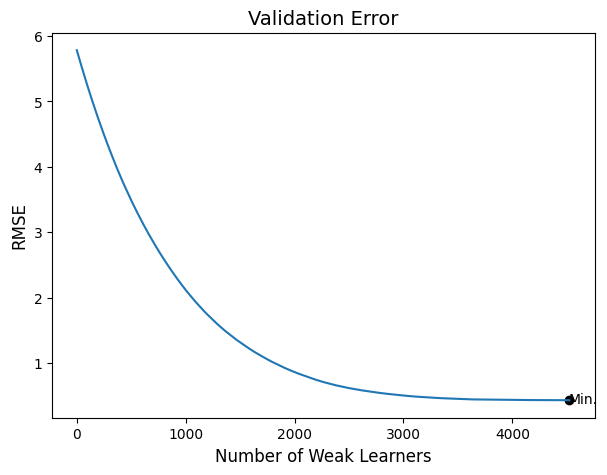

In [65]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'])
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Min.", fontsize=10)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

In [66]:
xgb_reg.score(valid['features'].values.tolist(), y_valid.values.tolist())

0.7133590893178348

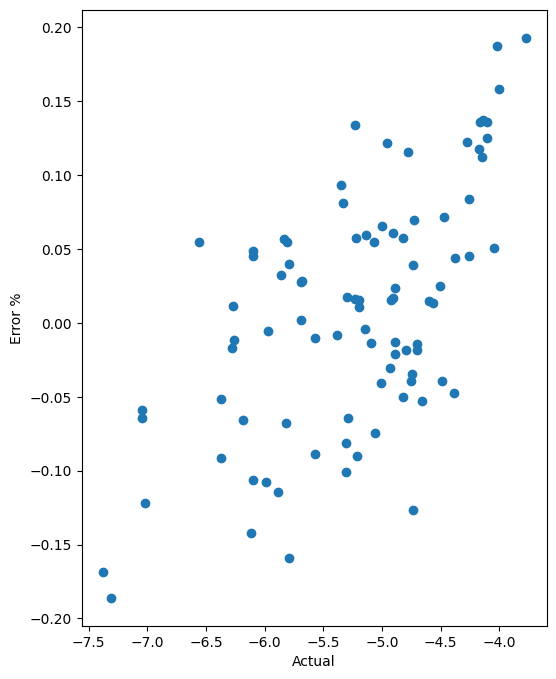

In [67]:
plt.figure(figsize=(6,8))
plt.scatter(y_valid, (pred-y_valid)/y_valid)
plt.xlabel('Actual')
plt.ylabel('Error %')
plt.show()

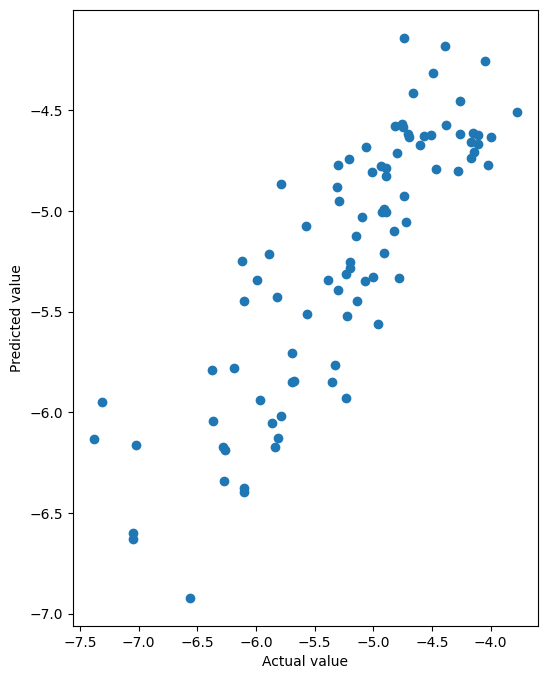

In [68]:
plt.figure(figsize=(6,8))
plt.scatter(y_valid, pred)
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

In [69]:
MAE = mean_absolute_error(y_valid, pred)

In [70]:
MAE

0.3428146826971436

In [71]:
R2

0.7133590893178348